## Number of detectable and mappable xQTL loci in ROSMAP multi−context fine−mapping

Author: Anqi Wang and Jenny Empawi

* Prepare the input dataset for the bar plot using the ROSMAP exported multicontext top loci summary results
* We only consider three categories in the detectable and mappable:
  * 1: 1-3 loci
  * 2: 4~10 loci
  * 3: >10 loci

#### Load libraries

In [1]:
library(data.table)
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(RColorBrewer)
library(ggrepel)
library(viridis)
library(showtext)
font_add_google("Noto Sans", "Noto Sans")
showtext_auto()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: sysfonts

Loading required package: showtextdb



### Multi-context Detectable and Mappable xQTL loci

#### Load and prepare data

In [2]:
#ROSMAP_multicontext_top_loci <- fread("/Staging/variant_gene_summary/xQTL_loci_summary/xQTL_finemapping/multi_context_finemapping/ROSMAP.exported.toploci.bed.gz") # path in synapse
ROSMAP_multicontext_top_loci <- fread("/data/analysis_result/multi_context/ROSMAP_All/mvsusie_export_0822/summary/ROSMAP.exported.toploci.bed.gz") # path in cloud
ROSMAP_multicontext_top_loci_pip_sum <- ROSMAP_multicontext_top_loci %>% group_by(gene_ID)%>% mutate(pip_sum = sum(PIP))
coverage <- "cs_coverage_0.95"
multicontext_top_loci_detectable_mappable_summary <- ROSMAP_multicontext_top_loci_pip_sum %>% group_by(gene_ID)%>%
                                                     filter(pip_sum >= 0.95)%>%
                                                     mutate(n_detectable = ifelse(all(.data[[coverage]] == 0), 0, n_distinct(.data[[coverage]][.data[[coverage]] != 0])))%>%
                                                     mutate(n_mappable = ifelse(n_detectable == 0, 0, NA)) %>%
                                                          left_join(
                                                                    ROSMAP_multicontext_top_loci_pip_sum %>%
                      
                                                              filter(.data[[coverage]] != 0) %>%  # Remove zero values
                                                                    group_by(gene_ID, .data[[coverage]]) %>%
                                                                    summarize(variant_count = n(), .groups = "drop") %>%
                                                                    group_by(gene_ID) %>%
                                                                    summarize(n_mappable = sum(variant_count <= 3), .groups = "drop"),
                                                                    by = "gene_ID"
                                                                    )%>%
                                                    mutate(n_mappable = coalesce(n_mappable.x, n_mappable.y))%>%
                                                    select(-c(n_mappable.x, n_mappable.y))

head(multicontext_top_loci_detectable_mappable_summary) 

#chr,start,end,a1,a2,variant_ID,gene_ID,event_ID,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,PIP,conditional_effect,lfsr,pip_sum,n_detectable,n_mappable
<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,940389,940390,G,A,chr1:940390:A:G,ENSG00000187634,AC_DeJager_eQTL,1,0,0,0.06092993,0.262068508583204,1.19547510906484e-09,0.9939133,1,1
1,955678,955679,T,C,chr1:955679:C:T,ENSG00000187634,AC_DeJager_eQTL,1,1,1,0.45517519,0.281173816124936,1.19547510906484e-09,0.9939133,1,1
1,956564,956565,G,A,chr1:956565:A:G,ENSG00000187634,AC_DeJager_eQTL,1,1,1,0.47780813,0.281141277716978,1.19547510906484e-09,0.9939133,1,1
1,975522,975523,C,T,chr1:975523:T:C,ENSG00000187642,AC_DeJager_eQTL;DLPFC_DeJager_eQTL;PCC_DeJager_eQTL,2,0,0,0.15647830,-0.414958003019747;-0.476991256681064;-0.814552889483275,2.05782701493157e-08;1.65752120443744e-11;7.69995270053291e-11,1.9998046,2,2
1,978508,978509,A,G,chr1:978509:G:A,ENSG00000187642,AC_DeJager_eQTL;DLPFC_DeJager_eQTL;PCC_DeJager_eQTL,1,1,1,0.48748070,0.266475188678232;0.387803773749533;0.512932801018734,3.94868519372529e-13;3.6064916443111e-41;7.32107100334037e-25,1.9998046,2,2
1,978952,978953,G,C,chr1:978953:C:G,ENSG00000187642,,0,0,0,0.02500625,,,1.9998046,2,2


#### Summarize data

In [3]:
multicontext_top_loci_bar_plot_input <- multicontext_top_loci_detectable_mappable_summary %>%
  group_by(gene_ID) %>% filter(pip_sum >=0.95) %>% ungroup() %>%
  select(gene_ID, n_detectable, n_mappable) %>% filter (n_detectable!=0)%>%
  unique() %>%
  mutate(
    n_detectable_category = case_when(
      n_detectable >= 1 & n_detectable <= 3 ~ "1",
      n_detectable >= 4 & n_detectable <= 10 ~ "2",
      n_detectable > 10 ~ "3"
    ),
    n_mappable_category = case_when(
      n_mappable >= 1 & n_mappable <= 3 ~ "1",
      n_mappable >= 4 & n_mappable <= 10 ~ "2",
      n_mappable > 10  ~ "3",
    )
  ) %>%
  pivot_longer(
    cols = c(n_detectable, n_mappable),
    names_to = "category_type",
    values_to = "count",
    names_prefix = "n_"
  ) %>%
  mutate(subcategory = if_else(category_type == "detectable", n_detectable_category, n_mappable_category),
         subcategory = factor(subcategory, levels = rev(c("1", "2", "3")))) %>%
  group_by(category_type, subcategory) %>%
  summarise(gene_count = n(), .groups = 'drop') %>%
  mutate(log_gene_count = log1p(gene_count))

multicontext_top_loci_bar_plot_input <- multicontext_top_loci_bar_plot_input %>% filter(!is.na(subcategory))
multicontext_top_loci_bar_plot_input$subcategory <- factor(multicontext_top_loci_bar_plot_input$subcategory,
                                                           levels = as.character(1:3))

head(multicontext_top_loci_bar_plot_input)

category_type,subcategory,gene_count,log_gene_count
<chr>,<fct>,<int>,<dbl>
detectable,3,7,2.0794415
detectable,2,1432,7.2675254
detectable,1,8304,9.0246130
mappable,3,1,0.6931472
mappable,2,270,5.6021188
mappable,1,5317,8.5788526


#### Multicontext top loci bar plot

In [4]:
# Bar plot settings
# Assign two colors manually
bar_colors <- c("detectable" = "#66c2a5", "mappable" = "#fc8d62")
x_axis_labels <- c(
                   "1" = "1~3", 
                   "2" = "4~10", 
                   "3" = ">10"
                   )
resources    <- unique(multicontext_top_loci_bar_plot_input$subcategory)
pos_map      <- setNames(seq_along(resources), resources)
w            <- 0.25

In [5]:
p1 <- ggplot(multicontext_top_loci_bar_plot_input, aes(x = subcategory, y = gene_count, fill = category_type)) +
        geom_bar(stat = "identity", position = position_dodge(width = 0.5), width = 0.5) +
        geom_text(aes(label = gene_count), position = position_dodge(width = 0.5), vjust = -0.3, size = 12, fontface = "bold") +
        scale_fill_manual(values = bar_colors, name = "Type") +
        scale_x_discrete(labels = x_axis_labels) + 
        #scale_y_continuous(breaks = pos_map, labels = x_axis_labels[names(pos_map)]) +
        labs(
            title = "Multi-context Detectable and Mappable xQTL loci",
            x = "Category",
            y = "Number of xQTL loci") +
        theme_minimal() +
        theme(
            text = element_text(family = "Noto Sans"),
            plot.title  = element_text(size = 40, face = "bold", hjust = 1),
            plot.title.position = "plot",
            legend.position = c(0.8, 0.8),  # adjust position，c(x, y)，x the smaller it is towards the left
            legend.justification = c(0, 1),
            axis.text.x  = element_text(hjust = 1, size = 32, color = "black"),
            axis.text.y  = element_text(size = 32, color ="black"),
            axis.title   = element_text(size = 32, face = "bold"),
            legend.title = element_text(size = 36, face = "bold"),
            legend.text  = element_text(size = 32),
            panel.grid   = element_blank(),        # removes both x and y grid lines
            panel.background = element_rect(fill = "white", colour = NA),
            panel.spacing = unit(0.1,"lines"),
            plot.background  = element_rect(fill = "white", colour = NA),
            axis.line = element_line(color = "black", size = 0.6),
            legend.spacing.y = unit(20, "pt"),
            legend.key.size = unit(1.2, "lines"))

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


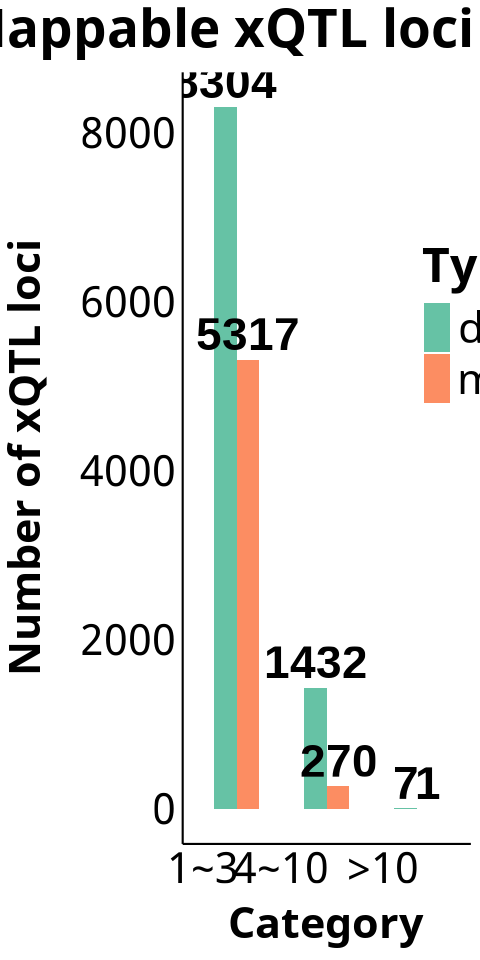

In [6]:
options(repr.plot.width = 4, repr.plot.height = 8)
p1
ggsave("Figure_2b_multi_context_detectable_mappable_xQTL_loci.png", p1, width = 4, height = 4, dpi = 300)

### Multi-context fine-mapping vs single-context fine-mapping

#### Load and prepare data

In [7]:
# summarize the multi-context results
multicontext_top_loci_integrated <- ROSMAP_multicontext_top_loci_pip_sum %>%
  separate_rows(event_ID, conditional_effect, lfsr, sep = ";")%>%
  mutate(effect_sign = case_when(
          conditional_effect > 0 ~ "+1",
          conditional_effect < 0 ~ "-1",
          conditional_effect == 0 ~ "0",
          TRUE ~ NA_character_))

coverage <- "cs_coverage_0.95"

multicontext_top_loci_integrated_detectable_mappable_pip_sum_95 <- multicontext_top_loci_integrated %>%
                                                                   group_by(gene_ID)%>% filter(pip_sum >=0.95) %>% ungroup()%>%
                                                                   group_by(event_ID, gene_ID)%>%
                                                                   mutate(event_ID_n_detectable = ifelse(all(.data[[coverage]] == 0), 0, n_distinct(.data[[coverage]][.data[[coverage]] != 0])))%>%
                                                                   group_by(event_ID, gene_ID, .data[[coverage]])%>%
                                                                   mutate(variants_count = n())%>%
                                                                   left_join(multicontext_top_loci_integrated %>%
                                                                   group_by(event_ID, gene_ID, .data[[coverage]]) %>%
                                                                   summarize(event_ID_detectable_variant_count = n(), .groups = "drop") %>%
                                                                   group_by(event_ID,gene_ID) %>%
                                                                   summarize(event_ID_n_mappable = sum(event_ID_detectable_variant_count <= 3),.groups = "drop"), by = c("gene_ID","event_ID"))

# detectable
multicontext_detectable_sum <- multicontext_top_loci_integrated_detectable_mappable_pip_sum_95 %>%
                                   filter(event_ID!="")%>%
                                   group_by(event_ID)%>%
                                   select(event_ID,gene_ID,event_ID_n_detectable)%>%
                                   ungroup()%>%
                                   unique()%>%
                                   group_by(event_ID)%>%
                                   mutate(event_ID_n_detectable_sum = sum(event_ID_n_detectable))%>%
                                   select(event_ID, event_ID_n_detectable_sum) %>% unique() %>% rename(resource = event_ID)

# mappable
multicontext_mappable_sum <- multicontext_top_loci_integrated_detectable_mappable_pip_sum_95 %>%
                                filter(event_ID!="") %>%
                                group_by(event_ID) %>%
                                select(event_ID,gene_ID,event_ID_n_mappable) %>%
                                ungroup() %>%
                                unique() %>%
                                group_by(event_ID) %>%
                                mutate(event_ID_n_mappable_sum = sum(event_ID_n_mappable)) %>%
                                select(event_ID, event_ID_n_mappable_sum) %>% 
                                unique() %>% 
                                rename(context = event_ID)

In [9]:
# summarize the single-context results
#singlecontext_top_loci_integrated_detectable_mappable <- readRDS("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_2b/single_context_top_loci_integrated.rds") # path in BU cluster
#data <- readRDS("/Staging/variant_gene_summary/xQTL_loci_summary/xQTL_finemapping/single_context_finemapping/consolidated/FunGen_xQTL_single_context_top_loci_integrated.rds") #  path in synapse
singlecontext_top_loci_integrated_detectable_mappable <- readRDS("/data/interactive_analysis/aw3600/Figure_2b/single_context_top_loci_integrated.rds") 

# detectable
singlecontext_detectable_sum <- singlecontext_top_loci_integrated_detectable_mappable %>% 
                                    filter(gene_ID %in% multicontext_top_loci_integrated$gene_ID) %>%
                                    filter(resource %in% unique(multicontext_top_loci_integrated$event_ID)[-1]) %>% 
                                    group_by(resource,gene_ID) %>%
                                    select(resource, gene_ID, event_ID_n_detectable) %>%
                                    ungroup() %>%
                                    unique() %>%
                                    group_by(resource) %>%
                                    mutate(event_ID_n_detectable_sum = sum(event_ID_n_detectable)) %>%
                                    select(resource, event_ID_n_detectable_sum) %>%
                                    unique()

# mappable
singlecontext_mappable_sum <- singlecontext_top_loci_integrated_detectable_mappable %>%
                                    filter(gene_ID %in% multicontext_top_loci_integrated$gene_ID) %>%
                                    filter(resource %in% unique(multicontext_top_loci_integrated$event_ID)[-1]) %>%
                                    group_by(resource,gene_ID) %>%
                                    select(resource, gene_ID, event_ID_n_mappable) %>%
                                    ungroup() %>%
                                    unique() %>%
                                    group_by(resource) %>%
                                    mutate(event_ID_n_mappable_sum = sum(event_ID_n_mappable)) %>%
                                    select(resource, event_ID_n_mappable_sum) %>%
                                    unique() %>% 
                                    rename(context=resource)

#### Detectable comparison

In [61]:
multi_uni_detectable_compare <- multicontext_detectable_sum %>%
                                left_join(singlecontext_detectable_sum, by = "resource") %>%
                                # Optionally rename and select specific columns to tidy up the result
                                select(resource, everything()) %>%
                                rename(context = resource, multi_detectable_sum = event_ID_n_detectable_sum.x, uni_detectable_sum = event_ID_n_detectable_sum.y)

multi_uni_detectable_compare

context,multi_detectable_sum,uni_detectable_sum
<chr>,<dbl>,<dbl>
AC_DeJager_eQTL,14862,7930
DLPFC_DeJager_eQTL,14923,7309
PCC_DeJager_eQTL,13895,5273
Exc_mega_eQTL,9002,5833
Ast_Kellis_eQTL,3796,1139
Ast_mega_eQTL,4705,1895
Exc_DeJager_eQTL,9096,4233
Exc_Kellis_eQTL,8227,3517
Inh_DeJager_eQTL,6668,1964


In [62]:
# First create the cell_type and dataset classifications
multi_uni_detectable_compare <- multi_uni_detectable_compare %>%
  mutate(
    cell_type = case_when(
      str_detect(context, "Ast") ~ "Ast",
      str_detect(context, "Exc") ~ "Exc",
      str_detect(context, "Inh") ~ "Inh",
      str_detect(context, "Oli") ~ "Oli",
      str_detect(context, "OPC") ~ "OPC",
      str_detect(context, "Mic") ~ "Mic",
      str_detect(context, "monocyte") ~ "Monocyte",
      str_detect(context, "AC_") ~ "AC",
      str_detect(context, "DLPFC_") ~ "DLPFC",
      str_detect(context, "PCC_") ~ "PCC",
      TRUE ~ "Other"
    ),
    context_modality = case_when(
      str_detect(context, "DeJager") ~ "CUIMC1 eQTL",
      str_detect(context, "Kellis") ~ "MIT eQTL",
      str_detect(context, "mega") ~ "Mega eQTL",
      str_detect(context, "ROSMAP") ~ "ROSMAP eQTL",
      str_detect(context, "Bennett") ~ "Bennett pQTL",
      TRUE ~ "Other"
    )
  )


In [63]:
p2 <- ggplot(multi_uni_detectable_compare, 
             aes(x = uni_detectable_sum, y = multi_detectable_sum, 
                 color = cell_type, shape = context_modality)) +
      geom_point(size = 5, stroke = 1.2, alpha = 0.8) +
      scale_x_continuous(limits = c(0, 18000)) +
      scale_y_continuous(limits = c(0, 15000)) +
      
      # Manual color scale with better visibility colors
      scale_color_manual(
        name = "Cell Type",
        values = c(
          "AC" = "#E41A1C",          # Red
          "Ast" = "#377EB8",         # Blue
          "DLPFC" = "#4DAF4A",       # Green
          "Exc" = "#984EA3",         # Purple
          "Inh" = "#FF7F00",         # Orange
          "Mic" = "#CC9900",         # Dark yellow/gold (replaced bright yellow)
          "Monocyte" = "#A65628",    # Brown
          "Oli" = "#F781BF",         # Pink
          "OPC" = "#666666",         # Dark gray
          "PCC" = "#66C2A5",         # Teal/Green
          "Protein QTL" = "#000000"  # Black
        )
      ) +
      
      # Shape scale for datasets - using more distinct shapes
      scale_shape_manual(values = c(0, 1, 2, 4, 5), name = "Context & modality") +
      
      labs(
        x = "Single-context fine-mapping detectable loci",
        y = "Multi-context fine-mapping detectable loci",
        title = "Detectable xQTL loci comparison"
      ) +
     theme_minimal() +
     theme(
          text = element_text(family = "Noto Sans", size =12),         
          axis.line = element_line(color = "black", linewidth = 1),
          plot.title = element_text(size = 44, face = "bold", hjust = 0.5),
          axis.title.x = element_text(size = 40, face = "bold", margin = margin(t=20)),
          axis.title.y = element_text(size = 40, face = "bold", margin= margin(r=20)),
          axis.text.x = element_text(size = 38),
          axis.text.y = element_text(size = 38),
          panel.grid = element_blank(),
          legend.text = element_text(size = 32),
          legend.title = element_text(size = 36, face = "bold"),
          legend.position = c(0.85, 0.38)
     ) +
     guides(
       color = guide_legend(override.aes = list(size = 5, shape = 16)),
       shape = guide_legend(override.aes = list(size = 5))
     ) + 
     geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray90", linewidth = 1.2)

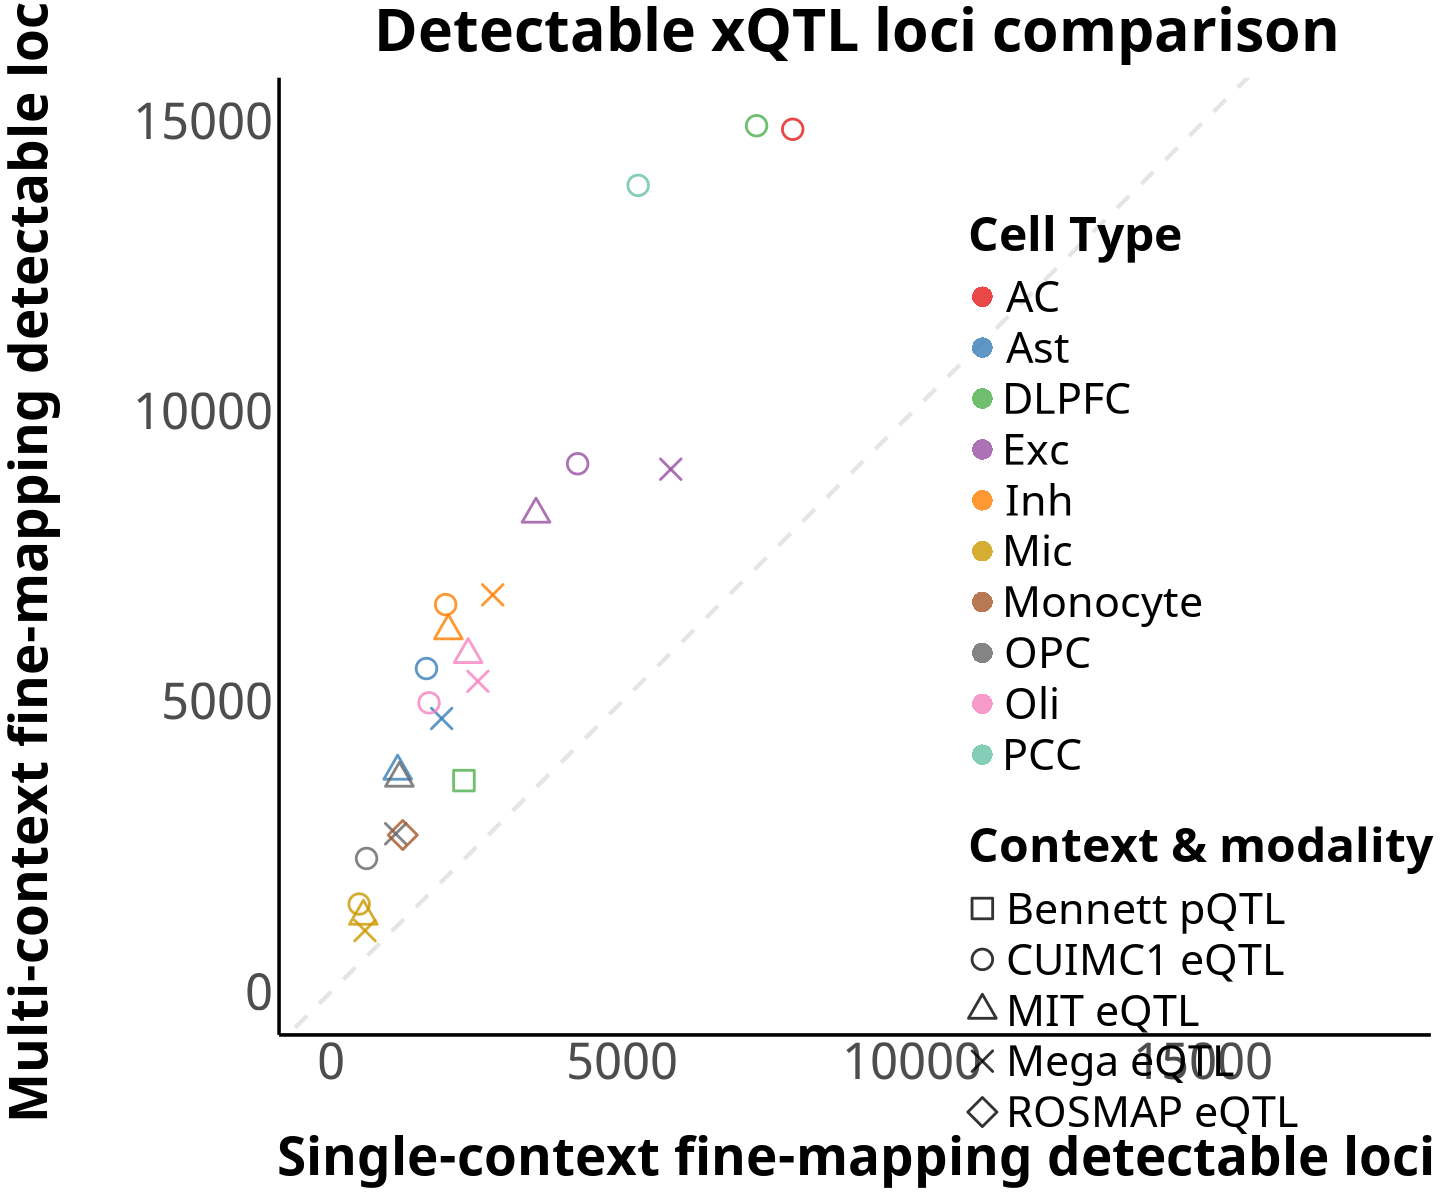

In [64]:
options(repr.plot.width = 12, repr.plot.height = 10)
p2
ggsave("Figure_2c_multi_context_detectable_comparison.png", p2, width = 8, height = 8, dpi = 300)

#### Mappable comparison

In [65]:
multi_uni_mappable_compare <- multicontext_mappable_sum %>%
  left_join(singlecontext_mappable_sum, by = "context") %>%
  # Optionally rename and select specific columns to tidy up the result
  select(context, everything())%>%rename(multi_mappable_sum = event_ID_n_mappable_sum.x, uni_mappable_sum = event_ID_n_mappable_sum.y)

multi_uni_mappable_compare

context,multi_mappable_sum,uni_mappable_sum
<chr>,<int>,<dbl>
AC_DeJager_eQTL,6183,2921
DLPFC_DeJager_eQTL,6373,2783
PCC_DeJager_eQTL,5895,1814
Exc_mega_eQTL,3477,2038
Ast_Kellis_eQTL,1546,397
Ast_mega_eQTL,1829,597
Exc_DeJager_eQTL,3553,1255
Exc_Kellis_eQTL,3226,1141
Inh_DeJager_eQTL,2663,539


In [66]:
# First create the cell_type and dataset classifications
multi_uni_mappable_compare <- multi_uni_mappable_compare %>%
  mutate(
    cell_type = case_when(
      str_detect(context, "Ast") ~ "Ast",
      str_detect(context, "Exc") ~ "Exc",
      str_detect(context, "Inh") ~ "Inh",
      str_detect(context, "Oli") ~ "Oli",
      str_detect(context, "OPC") ~ "OPC",
      str_detect(context, "Mic") ~ "Mic",
      str_detect(context, "monocyte") ~ "Monocyte",
      str_detect(context, "AC_") ~ "AC",
      str_detect(context, "DLPFC_") ~ "DLPFC",
      str_detect(context, "PCC_") ~ "PCC",
      TRUE ~ "Other"
    ),
    context_modality = case_when(
      str_detect(context, "DeJager") ~ "CUMC1 eQTL",
      str_detect(context, "Kellis") ~ "MIT eQTL",
      str_detect(context, "mega") ~ "Mega eQTL",
      str_detect(context, "ROSMAP") ~ "ROSMAP eQTL",
      str_detect(context, "Bennett") ~ "Bennett pQTL",
      TRUE ~ "Other"
    )
  )

In [67]:
p3 <- ggplot(multi_uni_mappable_compare, 
             aes(x = uni_mappable_sum, y = multi_mappable_sum, 
                 color = cell_type, shape = context_modality)) +
      geom_point(size = 5, stroke = 1.2, alpha = 0.8) +
      scale_x_continuous(limits = c(0, 7000)) +
      scale_y_continuous(limits = c(0, 7200)) +
      
      # Manual color scale with better visibility colors
      scale_color_manual(
        name = "Cell Type",
        values = c(
          "AC" = "#E41A1C",          # Red
          "Ast" = "#377EB8",         # Blue
          "DLPFC" = "#4DAF4A",       # Green
          "Exc" = "#984EA3",         # Purple
          "Inh" = "#FF7F00",         # Orange
          "Mic" = "#CC9900",         # Dark yellow/gold (replaced bright yellow)
          "Monocyte" = "#A65628",    # Brown
          "Oli" = "#F781BF",         # Pink
          "OPC" = "#666666",         # Dark gray
          "PCC" = "#66C2A5",         # Teal/Green
          "Protein QTL" = "#000000"  # Black
        )
      ) +
      
      # Shape scale for datasets - using same shapes as p2
      scale_shape_manual(values = c(0, 1, 2, 4, 5), name = "Context & modality") +
      
      labs(
        x = "Single-context fine-mapping mappable loci",
        y = "Multi-context fine-mapping mappable loci",
        title = "Mappable xQTL loci comparison"
      ) +
     theme_minimal() +
     theme(
          text = element_text(family = "Noto Sans", size = 12),         
          axis.line = element_line(color = "black", linewidth = 1),
          plot.title = element_text(size = 44, face = "bold", hjust = 0.5),
          axis.title.x = element_text(size = 40, face = "bold", margin = margin(t = 20)),
          axis.title.y = element_text(size = 40, face = "bold", margin = margin(r = 20)),
          axis.text.x = element_text(size = 38),
          axis.text.y = element_text(size = 38),
          panel.grid = element_blank(),
          legend.text = element_text(size = 32),
          legend.title = element_text(size = 36, face = "bold"),
          legend.position = c(0.85, 0.38)
     ) +
     guides(
       color = guide_legend(override.aes = list(size = 5, shape = 16)),
       shape = guide_legend(override.aes = list(size = 5))
     ) + 
     geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray90", linewidth = 1.2)

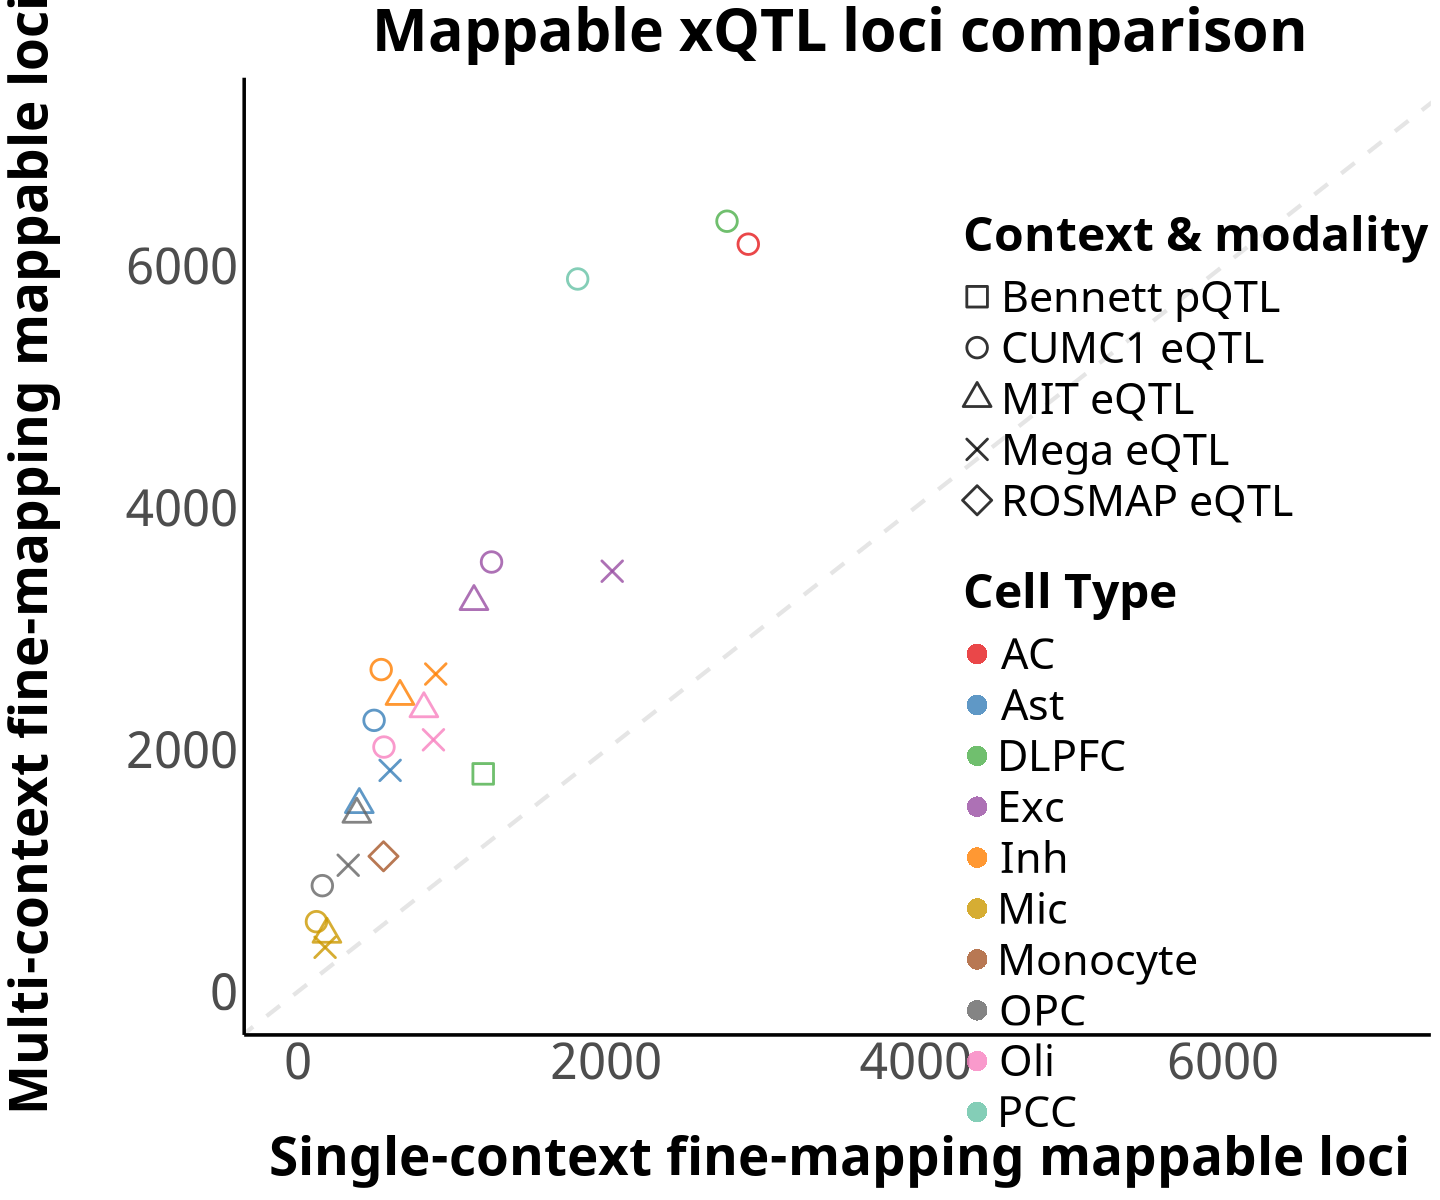

In [68]:
options(repr.plot.width = 12, repr.plot.height = 10)
p3
ggsave("Figure_2c_multi_context_mappable_comparison.png", p3, width = 8, height = 8, dpi = 300)

### Polish Version

#### Multicontext Detectable and Mappable xQTL loci

In [56]:
#bar_colors <- c("detectable" = "#DF6FDE", "mappable" = "#FF999B")
#color_palette <- c("#FFE1A0", "#FFBE91", "#FF999B", "#FF7AB8", "#DF6FDE")
bar_colors <- c("detectable" = "#66c2a5", "mappable" = "#fc8d62")
p1 <- ggplot(multicontext_top_loci_bar_plot_input, aes(x = subcategory, y = gene_count, fill = category_type)) +
        geom_bar(stat = "identity", position = position_dodge(width = 0.9), width = 0.9) +
        geom_text(aes(label = gene_count), position = position_dodge(width = 0.9), vjust = -0.3, size = 9, fontface = "bold") +
        scale_fill_manual(values = bar_colors, name = "Type") +
        scale_x_discrete(labels = x_axis_labels) + 
        #scale_y_continuous(breaks = pos_map, labels = x_axis_labels[names(pos_map)]) +
        labs(
            title = "Multi-context Detectable and Mappable xQTL loci",
            x = "Category",
            y = "Number of xQTL loci") +
        theme_minimal() +
        theme(
            text = element_text(family = "Noto Sans"),
            plot.title  = element_text(size = 32, face = "bold", hjust = 1, margin = margin(b=10)),
            plot.title.position = "plot",
            legend.position = c(0.675, 0.95),  # adjust position，c(x, y)，x the smaller it is towards the left
            legend.justification = c(0, 1),
            axis.text.x  = element_text(hjust = 1, size = 30, color = "black"),
            axis.text.y  = element_text(size = 30, color ="black"),
            axis.title.x   = element_text(size = 32, face = "bold", margin =  margin(t=10)),
            axis.title.y   = element_text(size = 32, face = "bold", margin =  margin(r=10)),
            legend.title = element_text(size = 30, face = "bold"),
            legend.text  = element_text(size = 28),
            panel.grid   = element_blank(),        # removes both x and y grid lines
            panel.background = element_rect(fill = "white", colour = NA),
            panel.spacing = unit(0.1,"lines"),
            plot.background  = element_rect(fill = "white", colour = NA),
            axis.line = element_line(color = "black", size = 0.6),
            legend.spacing.y = unit(10, "pt"),
            legend.key.size = unit(1.2, "lines"))

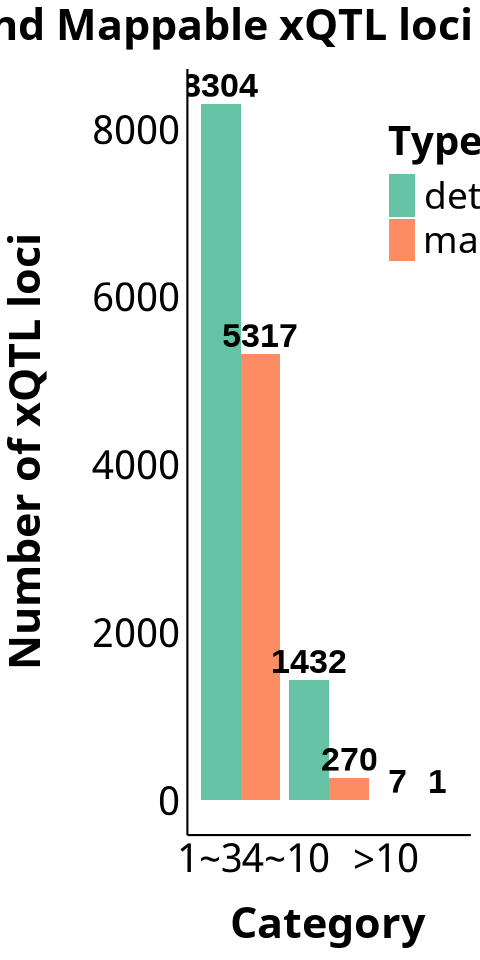

In [57]:
options(repr.plot.width = 4, repr.plot.height = 8)
p1
ggsave("Figure_2b_multi_context_detectable_mappable_xQTL_loci.png", p1, width = 4, height = 4, dpi = 300)

#### Detectable comparison

In [94]:
p2 <- ggplot(multi_uni_detectable_compare, 
             aes(x = uni_detectable_sum, y = multi_detectable_sum, 
                 color = cell_type, shape = context_modality)) +
      geom_point(size = 3, stroke = 2, alpha = 0.8) +
      scale_x_continuous(limits = c(0, 18000)) +
      scale_y_continuous(limits = c(0, 15000)) +
      
      # Manual color scale with better visibility colors
      scale_color_manual(
        name = "Cell Type",
        values = c(
          "AC" = "#E41A1C",          # Red
          "Ast" = "#377EB8",         # Blue
          "DLPFC" = "#4DAF4A",       # Green
          "Exc" = "#984EA3",         # Purple
          "Inh" = "#FF7F00",         # Orange
          "Mic" = "#CC9900",         # Dark yellow/gold (replaced bright yellow)
          "Monocyte" = "#A65628",    # Brown
          "Oli" = "#F781BF",         # Pink
          "OPC" = "#666666",         # Dark gray
          "PCC" = "#66C2A5",         # Teal/Green
          "Protein QTL" = "#000000"  # Black
        )
      ) +
      
      # Shape scale for datasets - using more distinct shapes
      scale_shape_manual(values = c(0, 1, 2, 4, 5), name = "Context & modality") +
      
      labs(
        x = "Single-context fine-mapping detectable loci",
        y = "Multi-context fine-mapping detectable loci",
        title = "Detectable xQTL loci comparison"
      ) +
     theme_minimal() +
     theme(
          text = element_text(family = "Noto Sans", size =12),         
          axis.line = element_line(color = "black", linewidth = 1),
          plot.title = element_text(size = 44, face = "bold", hjust = 0.5, margin = margin(b=20)),
          axis.title.x = element_text(size = 40, face = "bold", margin = margin(t=20)),
          axis.title.y = element_text(size = 40, face = "bold", margin= margin(r=20)),
          axis.text.x = element_text(size = 38),
          axis.text.y = element_text(size = 38),
          panel.grid = element_blank(),
          legend.text = element_text(size = 32),
          legend.title = element_text(size = 36, face = "bold"),
          legend.position = c(0.85, 0.38)
     ) +
     guides(
       color = guide_legend(override.aes = list(size = 5, shape = 16)),
       shape = guide_legend(override.aes = list(size = 5))
     ) + 
     geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray90", linewidth = 1.2)

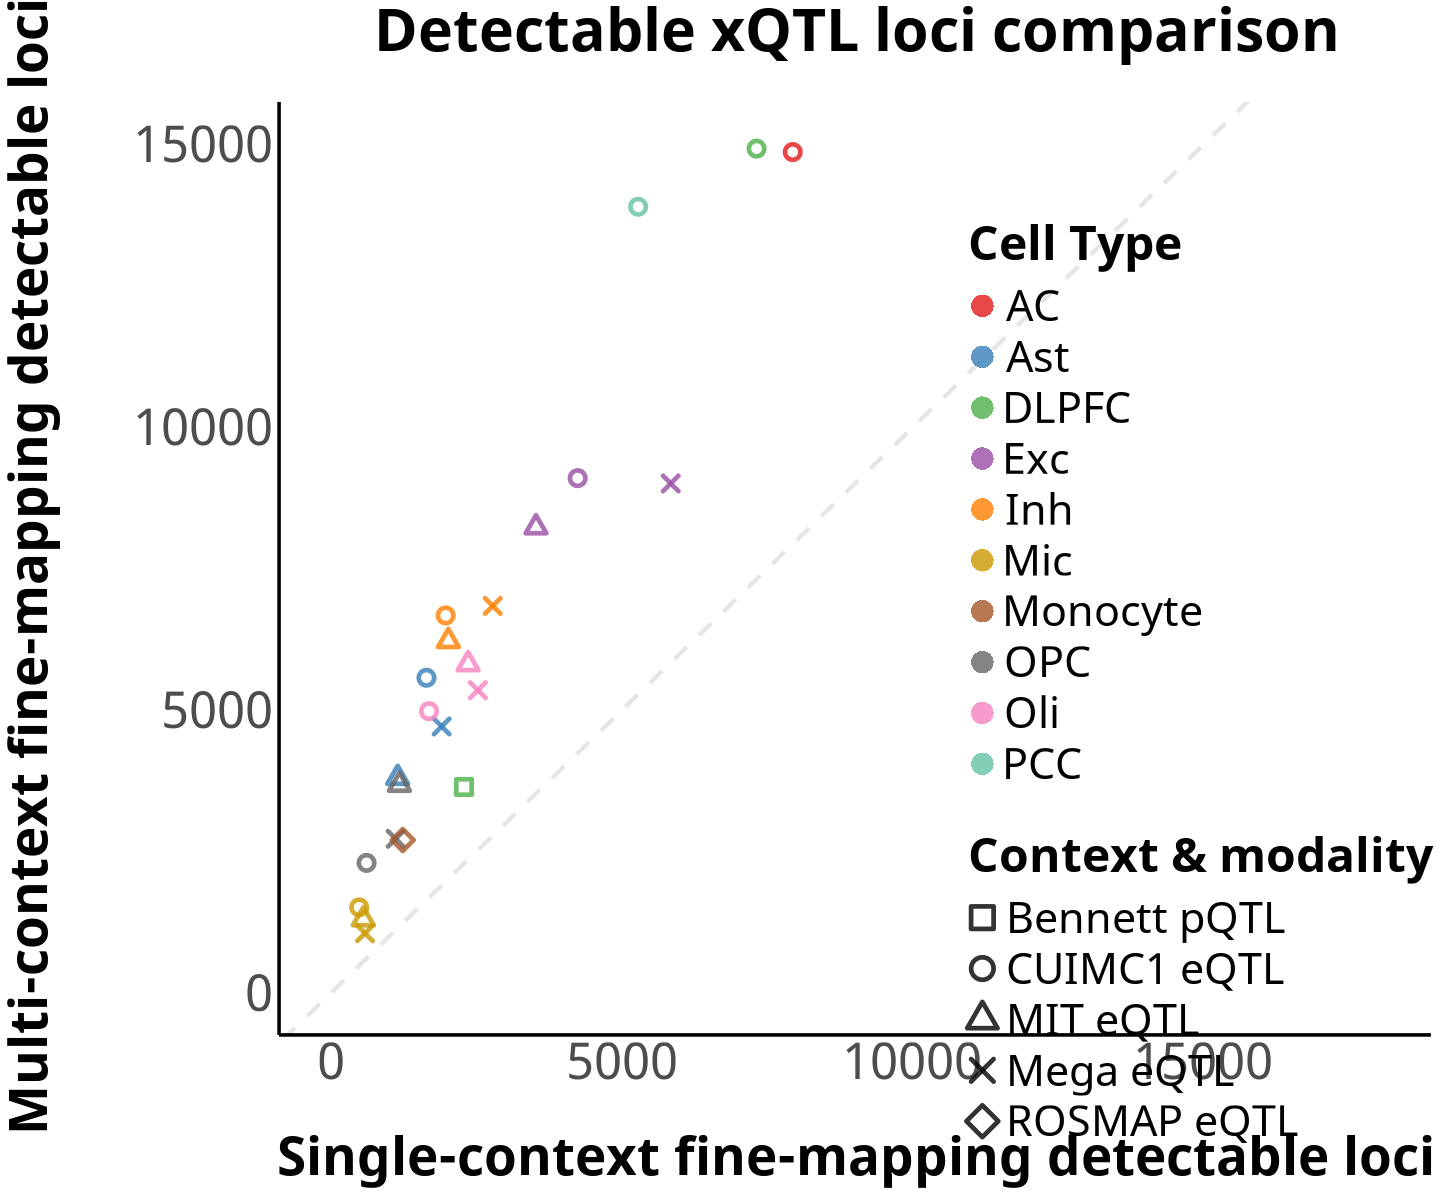

In [95]:
options(repr.plot.width = 12, repr.plot.height = 10)
p2
ggsave("Figure_2c_multi_context_detectable_comparison.png", p2, width = 6, height = 6, dpi = 300)

#### Mappable comparison

In [92]:
p3 <- ggplot(multi_uni_mappable_compare, 
             aes(x = uni_mappable_sum, y = multi_mappable_sum, 
                 color = cell_type, shape = context_modality)) +
      geom_point(size = 3, stroke =2, alpha = 0.8) +
      scale_x_continuous(limits = c(0, 7000)) +
      scale_y_continuous(limits = c(0, 7200)) +
      
      # Manual color scale with better visibility colors
      scale_color_manual(
        name = "Cell Type",
        values = c(
          "AC" = "#E41A1C",          # Red
          "Ast" = "#377EB8",         # Blue
          "DLPFC" = "#4DAF4A",       # Green
          "Exc" = "#984EA3",         # Purple
          "Inh" = "#FF7F00",         # Orange
          "Mic" = "#CC9900",         # Dark yellow/gold (replaced bright yellow)
          "Monocyte" = "#A65628",    # Brown
          "Oli" = "#F781BF",         # Pink
          "OPC" = "#666666",         # Dark gray
          "PCC" = "#66C2A5",         # Teal/Green
          "Protein QTL" = "#000000"  # Black
        )
      ) +
      
      # Shape scale for datasets - using same shapes as p2
      scale_shape_manual(values = c(0, 1, 2, 4, 5), name = "Context & modality") +
      
      labs(
        x = "Single-context fine-mapping mappable loci",
        y = "Multi-context fine-mapping mappable loci",
        title = "Mappable xQTL loci comparison"
      ) +
     theme_minimal() +
     theme(
          text = element_text(family = "Noto Sans", size = 12),         
          axis.line = element_line(color = "black", linewidth = 1),
          plot.title = element_text(size = 44, face = "bold", hjust = 0.5, margin = margin(b=20)),
          axis.title.x = element_text(size = 40, face = "bold", margin = margin(t = 20)),
          axis.title.y = element_text(size = 40, face = "bold", margin = margin(r = 20)),
          axis.text.x = element_text(size = 38),
          axis.text.y = element_text(size = 38),
          panel.grid = element_blank(),
          legend.text = element_text(size = 32),
          legend.title = element_text(size = 36, face = "bold"),
          legend.position = c(0.85, 0.38)
     ) +
     guides(
       color = guide_legend(override.aes = list(size = 5, shape = 16)),
       shape = guide_legend(override.aes = list(size = 5))
     ) + 
     geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray90", linewidth = 1.2)

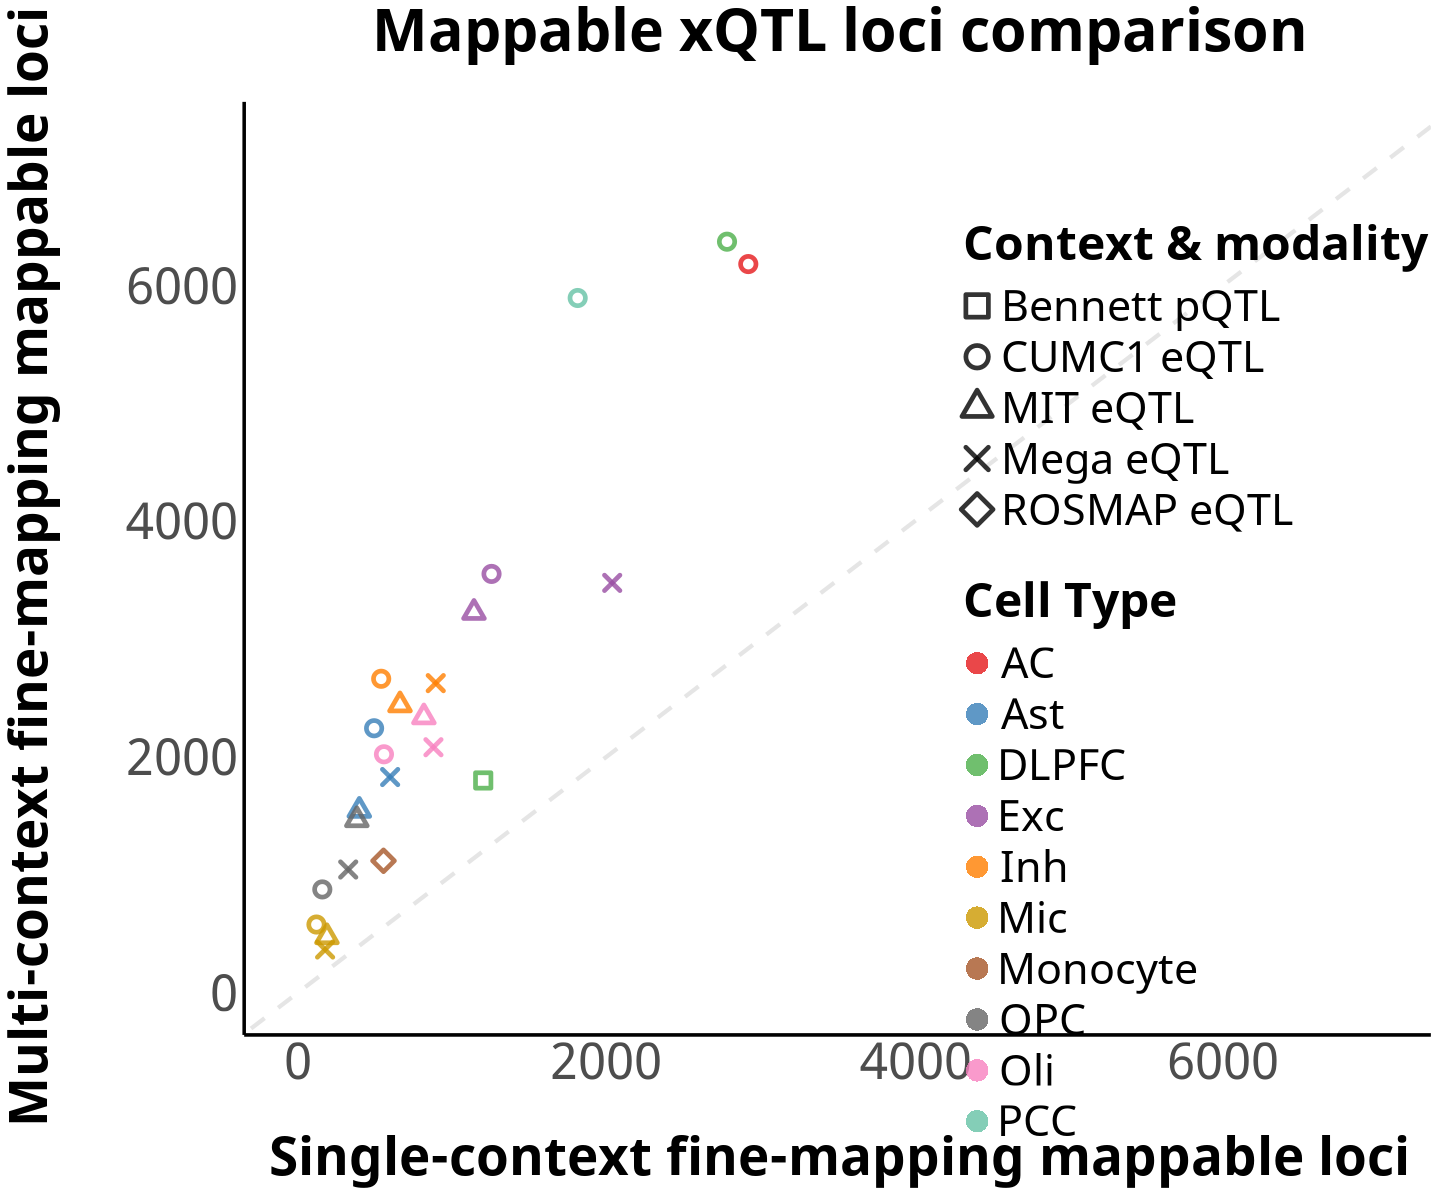

In [93]:
options(repr.plot.width = 12, repr.plot.height = 10)
p3
ggsave("Figure_2c_multi_context_mappable_comparison.png", p3, width = 6, height = 6, dpi = 300)